In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

zip_path = '/content/drive/My Drive/Satellite-Imagery-Road-Segmentation.zip'
extract_path = '/content/project_folder'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

project_path = '/content/project_folder/Satellite-Imagery-Road-Segmentation'
os.chdir(project_path)
print("Current working directory:", os.getcwd())

Current working directory: /content/project_folder/Satellite-Imagery-Road-Segmentation


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [27]:
# Specify the path to the old file
old_train_file_path = '/content/project_folder/Satellite-Imagery-Road-Segmentation/model.py'

# Remove the old file
if os.path.exists(old_train_file_path):
    os.remove(old_train_file_path)
    print(f"Removed old file: {old_train_file_path}")
else:
    print("Old file does not exist.")

Removed old file: /content/project_folder/Satellite-Imagery-Road-Segmentation/model.py


In [28]:
from google.colab import files

# Upload the new train.py file
uploaded = files.upload()

# Move the uploaded file to the correct folder
os.rename('model.py', '/content/project_folder/Satellite-Imagery-Road-Segmentation/model.py')
print("New file uploaded successfully!")

Saving model.py to model.py
New file uploaded successfully!


In [10]:
print("Verifying file:")
print(os.listdir('/content/project_folder/Satellite-Imagery-Road-Segmentation'))

Verifying file:
['readme-images', 'segment_images.py', '.gitignore', 'large_images_to_patches.py', '__pycache__', 'data', 'output', 'saved_model', '.git', 'evaluate_on_test.py', 'LICENSE', 'predictions', 'epfl_augmented', 'utils.py', 'visualize_predictions.ipynb', 'loss.py', 'config', 'road_segmentation_GUI.py', 'predicted_masks', 'README.md', 'merged_dataset_augmented', 'mask_to_submission.py', 'new_predictions', 'submission.csv']


In [11]:
!python train.py

Training dataset loaded: 2700 samples, 338 batches.
Validation dataset loaded: 276 samples, 35 batches.
Starting training...
Traceback (most recent call last):
  File "/content/project_folder/Satellite-Imagery-Road-Segmentation/train.py", line 184, in <module>
    train_losses, val_losses, val_f1_scores = train_model(
TypeError: train_model() got an unexpected keyword argument 'test_loader'


In [31]:
import shutil

# Path to the JSON file saved during training
local_json_path = "training_metrics.json"

# Path to upload the file to Google Drive
drive_json_path = "/content/drive/My Drive/training_metrics.json"

# Upload the file
shutil.copy(local_json_path, drive_json_path)
print(f"JSON file uploaded to {drive_json_path}")

JSON file uploaded to /content/drive/My Drive/training_metrics.json


In [35]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import sys
sys.path.append('/content/project_folder/Satellite-Imagery-Road-Segmentation')

from model import UnetLikeSegmentatorModel

# Load the trained model
def load_model(checkpoint_path):
    model = UnetLikeSegmentatorModel()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def predict(model, image_path):
    image = Image.open(image_path).convert('RGB')

    image_tensor = torch.tensor(np.array(image).transpose(2, 0, 1), dtype=torch.float32) / 255.0
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    # Predict the segmentation mask
    with torch.no_grad():
        output = model(image_tensor)
        predicted_mask = (output.squeeze(0).squeeze(0).numpy() > 0.5).astype(np.uint8) * 255  # Binary mask

    return image, predicted_mask

def plot_results(image, predicted_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [39]:
model = load_model("/content/drive/My Drive/best_model.pth")

<ipython-input-35-7a664ecff0de>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


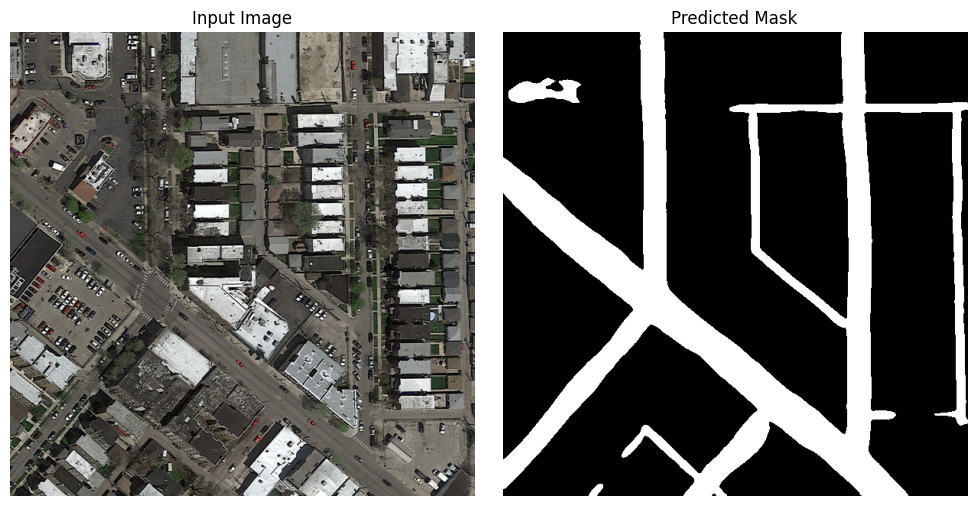

In [37]:
image, predicted_mask = predict(model, "/content/project_folder/Satellite-Imagery-Road-Segmentation/data/predict_ai_crowd/test_19.png")
plot_results(image, predicted_mask)

In [42]:
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

def extract_patches(input_image, patch_size=384):
    """
    Extracts 4 non-overlapping patches from a 608x608 input image.
    """
    patches = np.empty((4, input_image.shape[2], patch_size, patch_size))
    offsets = [(0, 0), (0, 224), (224, 0), (224, 224)]

    for i, (y, x) in enumerate(offsets):
        patches[i] = np.transpose(input_image[y:y+patch_size, x:x+patch_size, :], (2, 0, 1))

    return patches

def assemble_patches(patches):
    """
    Assembles 4 patches back into a 608x608 output.
    """
    output = np.empty((patches.shape[1], 608, 608))
    offsets = [(0, 0), (0, 224), (224, 0), (224, 224)]

    for i, (y, x) in enumerate(offsets):
        output[:, y:y+384, x:x+384] = patches[i]

    return output

def mask_to_submission_format(mask, index):
    """
    Converts a mask into the submission format.
    """
    submission = []
    for y in range(0, mask.shape[0], 16):
        for x in range(0, mask.shape[1], 16):
            patch = mask[y:y+16, x:x+16]
            prediction = 1 if np.mean(patch > 0.2) > 0.25 else 0
            submission.append([f"{index:03d}_{x}_{y}", prediction])
    return submission

def create_submission(model, test_images_path="/content/project_folder/Satellite-Imagery-Road-Segmentation/data/predict_ai_crowd/", patch_size=384, cuda=True):
    """
    Generates a submission file by predicting masks for the test set images.
    """
    all_submissions = []

    for index in tqdm(range(1, 51)):
        model.eval()

        # Load and preprocess the test image
        input_image = np.array(Image.open(f'{test_images_path}/test_{index}.png')).astype('float32') / 255
        input_patches = extract_patches(input_image)
        input_patches = torch.from_numpy(input_patches).float()

        # Perform inference
        if cuda:
            predictions = model(input_patches).detach().cpu().numpy()
        else:
            predictions = model(input_patches).detach().numpy()

        # Assemble patches into a full mask
        output_mask = assemble_patches(predictions)[0]

        # Visualize input and output side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row and 2 columns of plots
        axes[0].imshow(input_image)
        axes[0].set_title('Input Image')
        axes[0].axis('off')  # Hide axes for better visualization

        axes[1].imshow(output_mask, cmap='gray')
        axes[1].set_title('Output Mask')
        axes[1].axis('off')  # Hide axes for better visualization

        plt.tight_layout()  # Adjust spacing between plots
        plt.show()


        # Convert mask to submission format
        submission = mask_to_submission_format(output_mask, index)
        all_submissions.extend(submission)

    # Add header to submission
    submission = [['id', 'prediction']] + all_submissions
    return np.array(submission)

# Example usage
submission = create_submission(model, "/content/project_folder/Satellite-Imagery-Road-Segmentation/data/predict_ai_crowd/", 384, True)
np.savetxt("submit.csv", submission, delimiter=",", fmt='%s')

Output hidden; open in https://colab.research.google.com to view.

In [43]:
!cp /content/project_folder/Satellite-Imagery-Road-Segmentation/submit.csv /content/drive/My\ Drive/
print("File successfully uploaded to Google Drive.")

File successfully uploaded to Google Drive.
